In [1]:
import numpy, cv2
from matplotlib import pyplot as plt
from JokeFunc import GrayImg
from importlib import reload
GrayImg = reload(GrayImg)
from math import sin, cos, pi

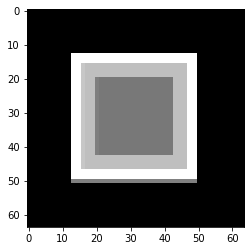

In [2]:
source = r'Image\temp.png'
temp = cv2.imread(source,64)
plt.imshow(temp,cmap='gray')

In [7]:
#Rotation: 0-pi/2
theta = pi*numpy.random.rand(1)[0]/2
Ar = numpy.array([[cos(theta),-sin(theta)],[sin(theta),cos(theta)]]) 

#Scaling: 1-2
s1 = numpy.random.rand(1)[0]+1
s2 = numpy.random.rand(1)[0]+1
Asc = numpy.array([[s1,0],[0,s2]])

#Shearing: 0-0.5
Sx = numpy.random.rand(1)[0]/2
Sy = numpy.random.rand(1)[0]/2
Ash = numpy.array([[1,Sx],[Sy,1]])

A = (Ar.dot(Asc)).dot(Ash)
cent = numpy.array(temp.shape)/2
b = cent-A.dot(cent)+cent*numpy.random.rand(2)/4

Ab = numpy.append(A,b.reshape(len(A),1),1)
Ab

array([[  1.51847531,   0.05643571, -12.49027618],
       [  0.47227831,   1.52795624, -24.68981112]])

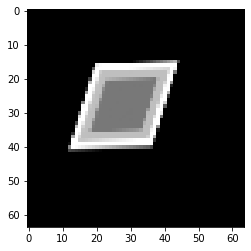

In [8]:
ref = GrayImg.AFT(temp,Ab)
plt.imshow(ref,cmap='gray')

# Steep and decent with constant alpha

0 ssd= 113.08670043945312


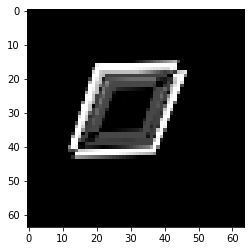

10 diif= 0.0073115307076367115 ssd= 62.23095703125


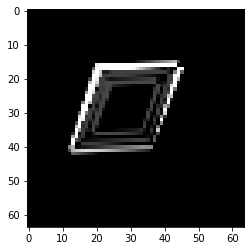

20 diif= 0.003072585663052056 ssd= 30.91559600830078


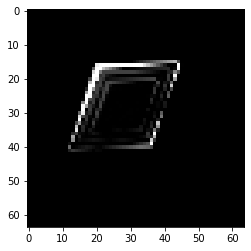

30 diif= 0.001464694094276285 ssd= 27.22412872314453


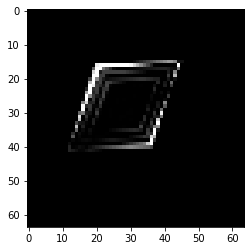

A does not change


In [39]:
A = numpy.zeros((2,3))
A[:,:-1] = numpy.eye(2)
A = Ab.copy()*(1+numpy.random.rand(2,3)/2)
A = A.reshape(6)
Imax = 100
eps = 1e-3
step_a = 1e-3
alpha = 1e-5

N = temp.size
F = GrayImg.AFT(temp,A.reshape(2,3))
da = (numpy.float16(F)-numpy.float16(ref)).reshape(N)/255
ssd0 = (numpy.linalg.norm(da)**2)/2
print(0,'ssd=',ssd0)
plt.imshow(numpy.uint8(255*abs(da.reshape(ref.shape))),cmap='gray')
plt.show()
for k in range(Imax):
    JacT = numpy.zeros((6,N))
    for i in range(6):
        Adf = A.copy()
        Adf[i]+=step_a
        Adb = A.copy()
        Adb[i]-=step_a
        Faf = GrayImg.AFT(temp,Adf.reshape(2,3)) #forward
        Fab = GrayImg.AFT(temp,Adb.reshape(2,3)) #backward
        dai = (numpy.float16(Faf)-numpy.float16(Fab))/255/(2*step_a) 
        JacT[i] = dai.reshape(N)
    grad = JacT.dot(da)
    A_old = A.copy()
    A -= alpha*grad
    F = GrayImg.AFT(temp,A.reshape(2,3))
    da = (numpy.float16(F)-numpy.float16(ref)).reshape(N)/255
    ssd = (numpy.linalg.norm(da)**2)/2
    diff = numpy.linalg.norm(A-A_old)
    
    if (k+1)%(Imax//10)==0:
        print(k+1,'diif=',diff,'ssd=',ssd)
        #plt.imshow(F,cmap='gray')
        plt.imshow(numpy.uint8(255*abs(da.reshape(ref.shape))),cmap='gray')
        plt.show()
    if diff<eps:
        print('A does not change')
        break
    if (ssd/ssd0)<eps:
        print('Converge')
        break   

# Steep and Descent with alpha by secant

1e-07 
 [[ 1.00002216e+00 -2.63540334e-05 -2.22267916e-07]
 [-1.28065274e-05  1.00002759e+00 -7.53577210e-08]]
1 diif= 4.5942379634157716e-05 ssd= 292.8956298828125


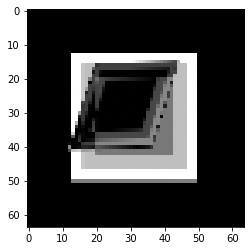

1e-07 
 [[ 1.00004392e+00 -5.30714350e-05 -3.72791179e-07]
 [-2.55503335e-05  1.00005508e+00 -5.21896757e-07]]
2 diif= 4.589139306416803e-05 ssd= 292.8956298828125


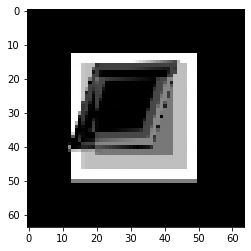

-0.7905258832302268 
 [[-172.50228695  208.54556578    2.14082664]
 [ 100.24041577 -223.18416586    1.3402386 ]]
3 diif= 365.9336337887485 ssd= 163.9747314453125


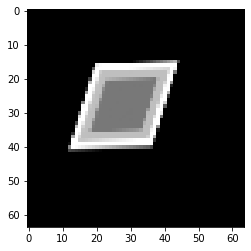

1e-07 
 [[-172.50228695  208.54556578    2.14082664]
 [ 100.24041577 -223.18416586    1.3402386 ]]
4 diif= 0.0 ssd= 163.9747314453125


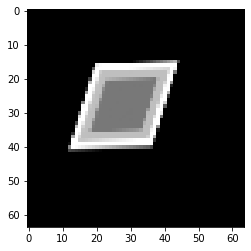

A does not change


In [11]:
A = numpy.zeros((2,3))
A[:,:-1] = numpy.eye(2)
#A = Ab.copy()*(1+numpy.random.rand(2,3)/2)
A = A.reshape(6)
Imax = 100
eps = 1e-3
step_a = 1e-2

alImax = 100
aleps = 1e-2

N = temp.size
F = GrayImg.AFT(temp,A.reshape(2,3))
da = (numpy.float16(F)-numpy.float16(ref)).reshape(N)/255
ssd0 = (numpy.linalg.norm(da)**2)/2
for k in range(Imax):
    JacT = numpy.zeros((6,N))
    for i in range(6):
        Adf = A.copy()
        Adf[i]+=step_a
        Adb = A.copy()
        Adb[i]-=step_a
        Faf = GrayImg.AFT(temp,Adf.reshape(2,3)) #forward
        Fab = GrayImg.AFT(temp,Adb.reshape(2,3)) #backward
        dai = (numpy.float16(Faf)-numpy.float16(Fab))/255/(2*step_a) #central diff
        JacT[i] = dai.reshape(N)
    grad = JacT.dot(da)
    
    #find alpha
    alpha_old = 2e-7
    Aal_old = A - alpha_old*grad
    Fal_old = GrayImg.AFT(temp,Aal_old.reshape(2,3))
    daal_old = (numpy.float16(Fal_old)-numpy.float16(ref)).reshape(N)/255
    ssdal_old = (numpy.linalg.norm(daal_old)**2)/2
    alpha = 1e-7
    for j in range(alImax):
        Aal = A - alpha*grad
        Fal = GrayImg.AFT(temp,Aal.reshape(2,3))
        daal = (numpy.float16(Fal)-numpy.float16(ref)).reshape(N)/255
        ssdal = (numpy.linalg.norm(daal)**2)/2
        if abs(ssdal-ssdal_old)<aleps: #avoid devided by zero
            break
        alpha_new = alpha - ssdal*(alpha-alpha_old)/(ssdal-ssdal_old)
        if abs((alpha_new-alpha)/alpha)<aleps:
            alpha = alpha_new
            break
        alpha_old = alpha
        ssdal_old = ssdal
        alpha = alpha_new
        
    
    A_old = A.copy()
    A -= alpha*grad
    F = GrayImg.AFT(temp,A.reshape(2,3))
    da = (numpy.float16(F)-numpy.float16(ref)).reshape(N)/255
    dT = numpy.float16(F).reshape(N)/255
    ssd = (numpy.linalg.norm(da)**2)/2
    diff = numpy.linalg.norm(A-A_old)
    print(alpha,'\n',A.reshape(2,3))
    if (k+1)%1==0:
        print(k+1,'diif=',diff,'ssd=',ssd)
        #plt.imshow(F,cmap='gray')
        plt.imshow(numpy.uint8(255*abs(da.reshape(ref.shape))),cmap='gray')
        plt.show()
    if diff<1e-8:
        print('A does not change')
        break
    if (ssd/ssd0)<eps:
        print('Converge')
        break   

# Gauss - Newton with constant alpha

0 ssd= 293.6524658203125


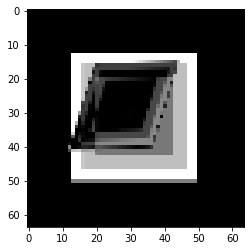

20 diif= 0.04119843110369183 rel_ssd= 0.8124389705524732


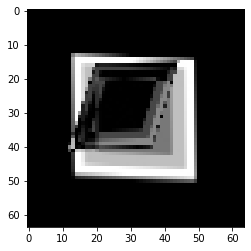

40 diif= 0.022680105846442006 rel_ssd= 0.7177399743348959


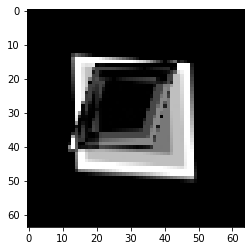

60 diif= 0.02980528537316868 rel_ssd= 0.6484870101068299


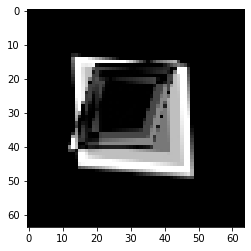

80 diif= 0.03425804448765798 rel_ssd= 0.5896576364908395


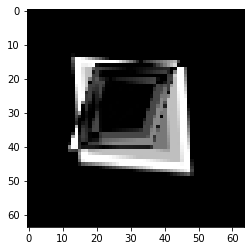

100 diif= 0.03882777139671554 rel_ssd= 0.5289256198347108


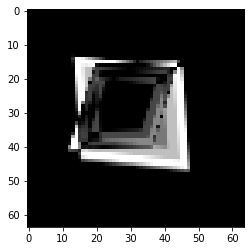

120 diif= 0.04114583936124545 rel_ssd= 0.4679583189398408


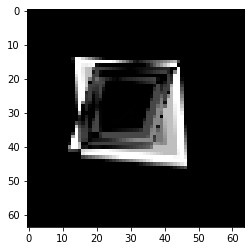

140 diif= 0.02855274774893768 rel_ssd= 0.3988276734171627


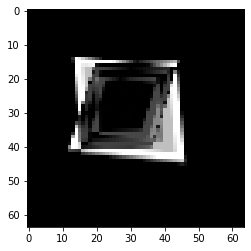

160 diif= 0.06753783271790459 rel_ssd= 0.32927322527717606


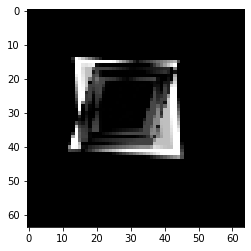

180 diif= 0.06799964232396692 rel_ssd= 0.27679403192798807


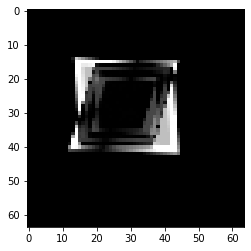

200 diif= 0.05488571948355753 rel_ssd= 0.2519379772456031


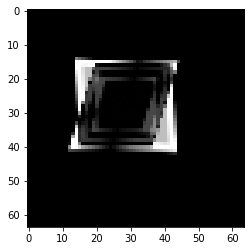

220 diif= 0.04116842404917835 rel_ssd= 0.23041237927653008


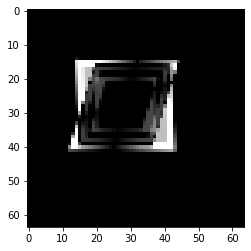

240 diif= 0.06965652036128132 rel_ssd= 0.20925758261656857


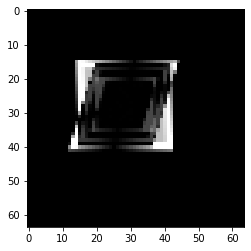

260 diif= 0.06932264376370734 rel_ssd= 0.17455263778157726


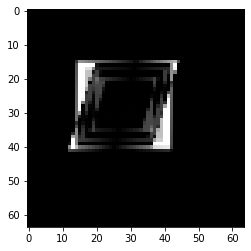

280 diif= 0.03404186438193866 rel_ssd= 0.16134388038581626


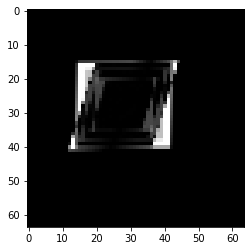

300 diif= 0.015787530081935012 rel_ssd= 0.15697127245956416


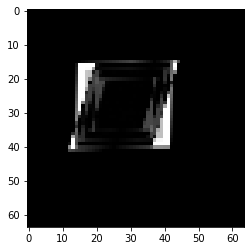

320 diif= 0.02712776116645597 rel_ssd= 0.15442720966610837


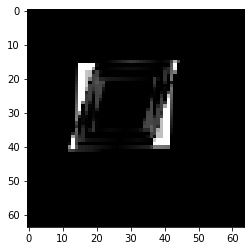

340 diif= 0.04138048383753474 rel_ssd= 0.15165274706819626


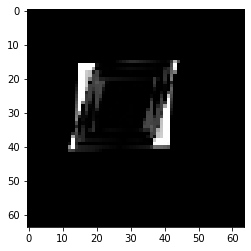

360 diif= 0.027349340909041956 rel_ssd= 0.1471669657603235


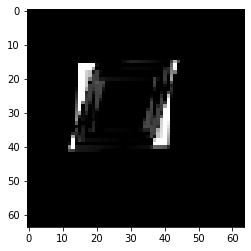

380 diif= 0.07839926535372871 rel_ssd= 0.13767879627585788


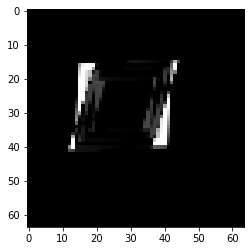

400 diif= 0.03007669368499176 rel_ssd= 0.12597693881903108


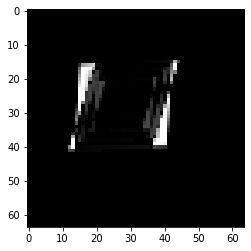

420 diif= 0.044447903956729894 rel_ssd= 0.1165489414079891


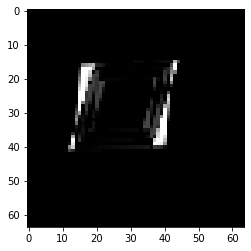

440 diif= 0.03070393225325552 rel_ssd= 0.10791076741321608


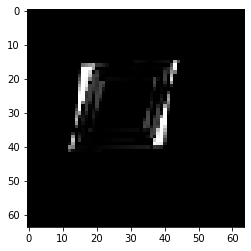

460 diif= 0.038949464104473586 rel_ssd= 0.10278411195372798


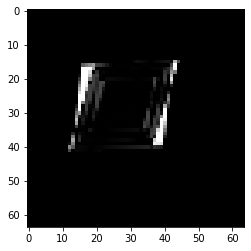

480 diif= 0.03742695409759013 rel_ssd= 0.09627596700367184


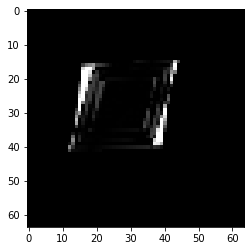

500 diif= 0.06697159113087181 rel_ssd= 0.08710299941677777


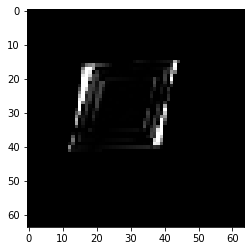

520 diif= 0.037276190237518186 rel_ssd= 0.080113451898299


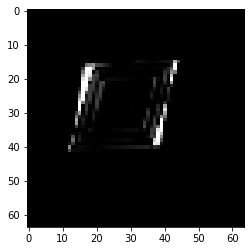

540 diif= 0.03711518329197056 rel_ssd= 0.07385358170369899


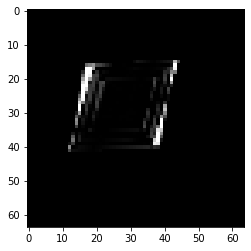

560 diif= 0.03882841893366387 rel_ssd= 0.06945314809064346


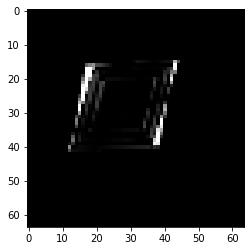

580 diif= 0.03810456934929604 rel_ssd= 0.06387759233555357


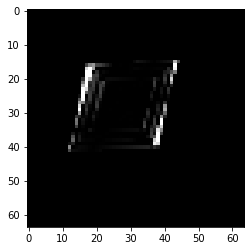

600 diif= 0.017715333131813196 rel_ssd= 0.05775794177837472


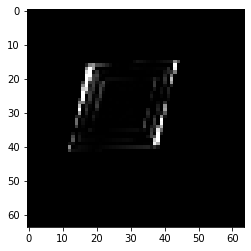

620 diif= 0.05845681266858149 rel_ssd= 0.05216703123252776


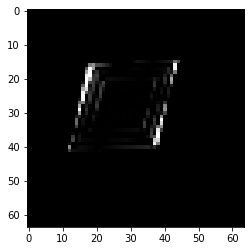

640 diif= 0.039545491462039895 rel_ssd= 0.04370552826507804


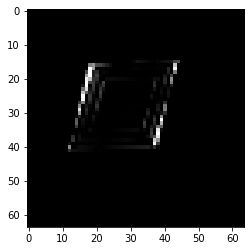

660 diif= 0.041893791776651194 rel_ssd= 0.03785044257131586


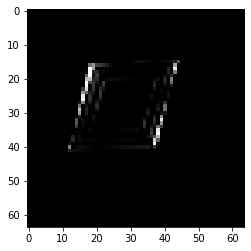

680 diif= 0.030434983532724377 rel_ssd= 0.032940728740967436


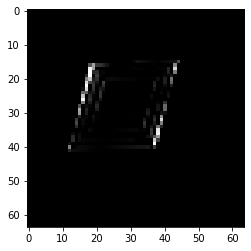

700 diif= 0.04450268508175259 rel_ssd= 0.027724074981678174


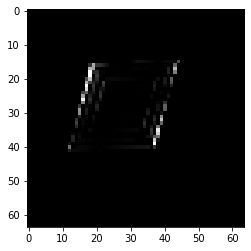

720 diif= 0.025124076253601538 rel_ssd= 0.01998276626090528


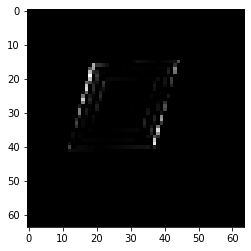

740 diif= 0.030490834508328412 rel_ssd= 0.015888025487185948


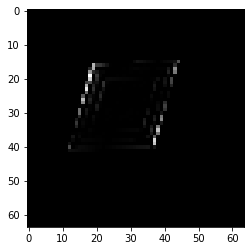

760 diif= 0.028713126525464067 rel_ssd= 0.011283069178970245


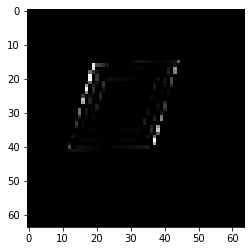

780 diif= 0.02731308466296423 rel_ssd= 0.007688723109110779


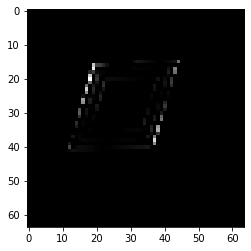

800 diif= 0.017104745613554743 rel_ssd= 0.005319778976230888


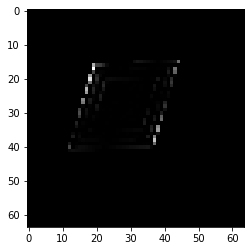

820 diif= 0.020205812001333565 rel_ssd= 0.002881010816008141


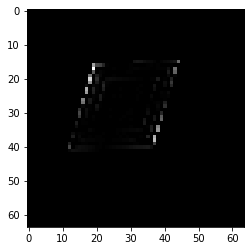

840 diif= 0.01156078594386091 rel_ssd= 0.0017260515797299719


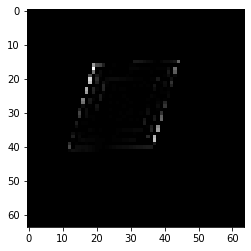

860 diif= 0.009002505222593115 rel_ssd= 0.0009690215050469716


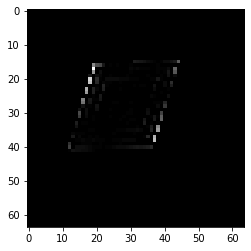

880 diif= 0.006949980507606138 rel_ssd= 0.0005816540394947042


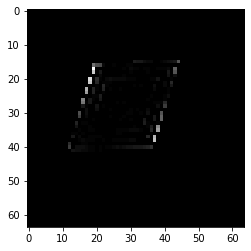

900 diif= 0.006215997613915087 rel_ssd= 0.0003671448846099166


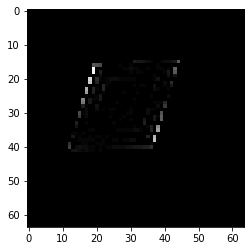

920 diif= 0.004980120678227932 rel_ssd= 0.00020262861693008316


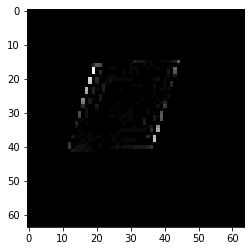

940 diif= 0.0038076188619715814 rel_ssd= 0.0001153269657197931


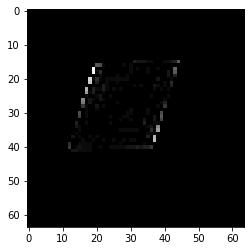

960 diif= 0.0025116003529452886 rel_ssd= 6.50337996763205e-05


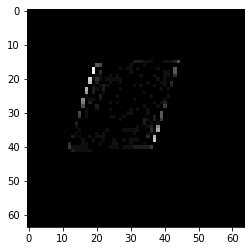

980 diif= 0.0022344148154260055 rel_ssd= 3.714729594210553e-05


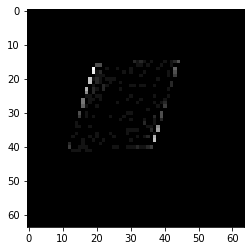

1000 diif= 0.0016994795194230459 rel_ssd= 1.96928368046722e-05


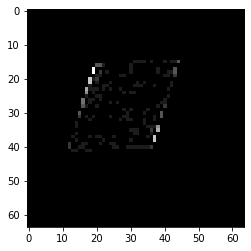

In [32]:
A = numpy.zeros((2,3))
A[:,:-1] = numpy.eye(2)
#A = Ab.copy()*(1+numpy.random.rand(2,3)/2)
A = A.reshape(6)
Imax = 1000
eps = 5e-2
step_a = 1e-2
alpha = 1e-1

N = temp.size
F = GrayImg.AFT(temp,A.reshape(2,3))
da = (numpy.float16(F)-numpy.float16(ref)).reshape(N)/255
ssd0 = (numpy.linalg.norm(da)**2)/2
print(0,'ssd=',ssd0)
plt.imshow(numpy.uint8(255*abs(da.reshape(ref.shape))),cmap='gray')
plt.show()

for k in range(Imax):
    JacT = numpy.zeros((6,N))
    for i in range(6):
        Adf = A.copy()
        Adf[i]+=step_a
        Adb = A.copy()
        Adb[i]-=step_a
        Faf = GrayImg.AFT(temp,Adf.reshape(2,3)) #forward
        Fab = GrayImg.AFT(temp,Adb.reshape(2,3)) #backward
        dai = (numpy.float16(Faf)-numpy.float16(Fab))/255/(2*step_a) 
        JacT[i] = dai.reshape(N)
    H = JacT.dot(numpy.transpose(JacT))
    invH = numpy.linalg.inv(H)
    grad = JacT.dot(da)
    A_old = A.copy()
    A -= alpha*invH.dot(grad)
    F = GrayImg.AFT(temp,A.reshape(2,3))
    da = (numpy.float16(F)-numpy.float16(ref)).reshape(N)/255
    rel_ssd = (numpy.linalg.norm(da)**2)/(2*ssd0)
    diff = numpy.linalg.norm(A-A_old)
    
    if (k+1)%20==0:
        print(k+1,'diif=',diff,'rel_ssd=',rel_ssd)
        #plt.imshow(F,cmap='gray')
        plt.imshow(numpy.uint8(255*abs(da.reshape(ref.shape))),cmap='gray')
        plt.show()
    if diff<1e-8:
        print('A does not change')
        break
    if rel_ssd<eps:
        print('Converge')
        break   

In [33]:
numpy.linalg.norm(A.reshape(2,3)-Ab)

0.09516901137268365

In [34]:
A.reshape(2,3),Ab

(array([[  1.51891149,   0.05709767, -12.52199365],
        [  0.47009249,   1.52703724, -24.6001178 ]]),
 array([[  1.51847531,   0.05643571, -12.49027618],
        [  0.47227831,   1.52795624, -24.68981112]]))

# Gauss - Newton with alpha by secant

0 ssd= 293.6524658203125


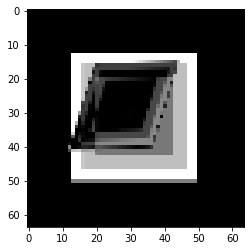

1 diif= 9.055086489632567 ssd= 182.28564453125
alpha 77.66679592129829 
 [[ 3.16221044 -2.52512249  6.79398444]
 [-1.78778497  2.62807054  4.35180198]]


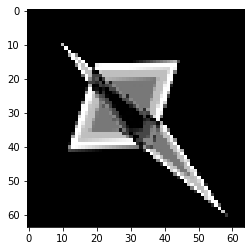

2 diif= 8.265085156507316 ssd= 156.7003173828125
alpha 29.375343938091145 
 [[ 4.22492077 -3.55048195 10.98488892]
 [-1.14118578  2.35370102 -2.58173016]]


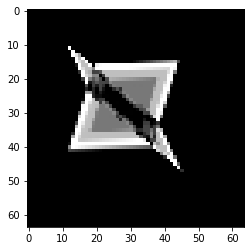

3 diif= 19.723229290592048 ssd= 159.19970703125
alpha 29.375343938091145 
 [[ 3.53439342 -2.42552419 -0.16220262]
 [-3.3226133   4.29380694 13.37079719]]


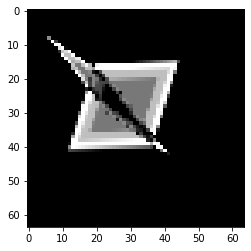

4 diif= 0.29361682755148233 ssd= 158.9210205078125
alpha 0.5 
 [[ 3.5131094  -2.39808623 -0.38187781]
 [-3.29599171  4.27236391 13.18217245]]


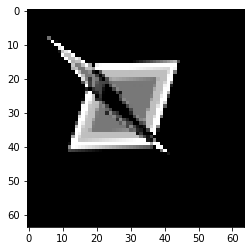

5 diif= 0.18817993410898723 ssd= 158.642578125
alpha 0.5 
 [[ 3.50094002 -2.3848134  -0.4849394 ]
 [-3.28581754  4.26675476 13.02618926]]


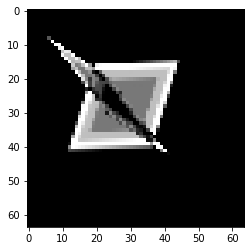

6 diif= 0.5889327773935737 ssd= 158.08642578125
alpha 0.5 
 [[ 3.45412288 -2.31500195 -1.06172404]
 [-3.27986432  4.26220368 12.9422866 ]]


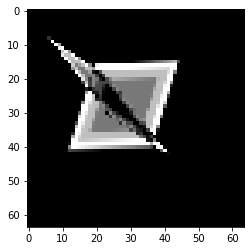

7 diif= 0.4779094181910398 ssd= 157.53125
alpha 0.5 
 [[ 3.41436786 -2.26523711 -1.30028745]
 [-3.24925264  4.24521586 12.5346075 ]]


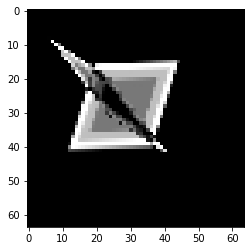

8 diif= 0.10047361387177466 ssd= 157.2540283203125
alpha 0.5 
 [[ 3.3992335  -2.24796783 -1.3714395 ]
 [-3.24740602  4.2443905  12.46751827]]


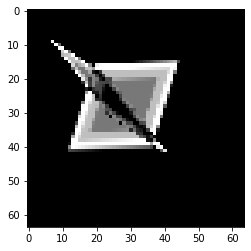

9 diif= 0.14723615973822507 ssd= 157.2540283203125
alpha 0.5 
 [[ 3.36646505 -2.21197353 -1.44259385]
 [-3.24749164  4.24760789 12.3482043 ]]


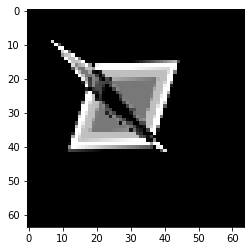

10 diif= 0.22247098590433323 ssd= 156.97705078125
alpha 0.5 
 [[ 3.34066194 -2.18049364 -1.62210445]
 [-3.24192159  4.24510215 12.22340368]]


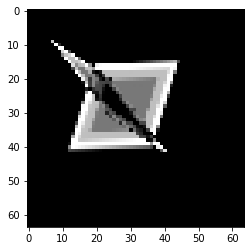

11 diif= 0.14912711788361185 ssd= 156.97705078125
alpha 0.5 
 [[ 3.33421072 -2.1794405  -1.56096406]
 [-3.24844515  4.24499599 12.35910723]]


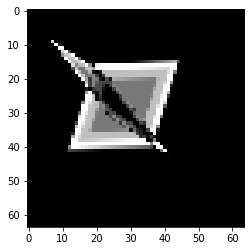

12 diif= 0.19259092681663115 ssd= 156.7003173828125
alpha 0.5 
 [[ 3.32119976 -2.16126787 -1.74766852]
 [-3.25335778  4.25034105 12.31811365]]


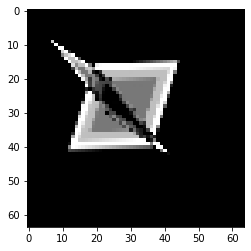

13 diif= 0.09328603281172483 ssd= 156.423828125
alpha 0.5 
 [[ 3.31158224 -2.1540261  -1.72973056]
 [-3.24899667  4.24806625 12.22749698]]


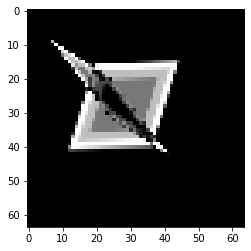

14 diif= 0.529316772867434 ssd= 156.1475830078125
alpha 0.5 
 [[ 3.3000809  -2.13638862 -1.94153865]
 [-3.21324381  4.22817331 11.74459304]]


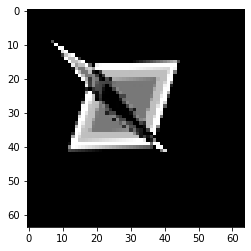

15 diif= 0.11499720048689799 ssd= 155.87158203125
alpha 0.5 
 [[ 3.26856564 -2.10145416 -2.03996319]
 [-3.22328965  4.23599138 11.77867084]]


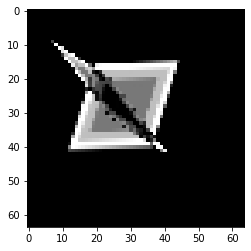

16 diif= 0.13923715649801657 ssd= 155.87158203125
alpha 0.5 
 [[ 3.26312782 -2.09328785 -2.16584012]
 [-3.21768194  4.23129429 11.72042811]]


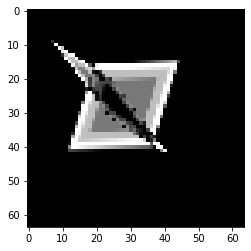

17 diif= 0.03874587273865708 ssd= 155.87158203125
alpha 0.5 
 [[ 3.2470203  -2.07807495 -2.19590414]
 [-3.2116569   4.2240619  11.71619671]]


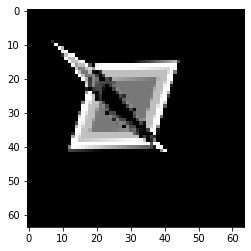

18 diif= 0.14388078868532272 ssd= 155.5958251953125
alpha 0.5 
 [[ 3.22616219 -2.05395928 -2.32294167]
 [-3.20277003  4.21628778 11.65782628]]


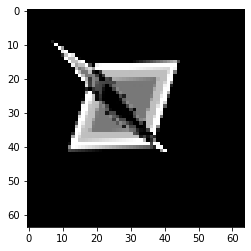

19 diif= 0.3157315592115185 ssd= 155.0450439453125
alpha 0.5 
 [[ 3.19297869 -2.0123648  -2.57122446]
 [-3.18939975  4.20877104 11.47080874]]


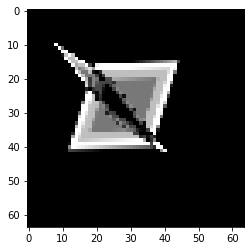

20 diif= 0.13558299236283125 ssd= 155.0450439453125
alpha 0.5 
 [[ 3.16018648 -1.97527489 -2.69480392]
 [-3.18964049  4.20762172 11.49646993]]


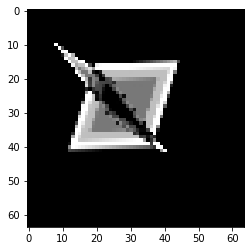

21 diif= 0.10656145181502744 ssd= 154.77001953125
alpha 0.5 
 [[ 3.13930586 -1.95282899 -2.75854759]
 [-3.18742553  4.20802653 11.41680062]]


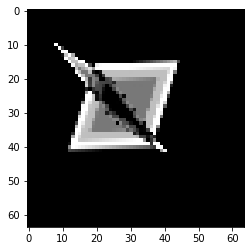

22 diif= 0.18007188433100813 ssd= 154.4952392578125
alpha 0.5 
 [[ 3.11287654 -1.92249696 -2.88089473]
 [-3.18339983  4.20818469 11.29101394]]


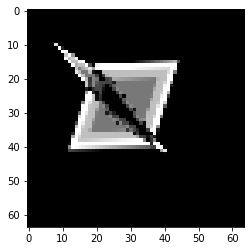

23 diif= 0.22564330704026922 ssd= 154.77001953125
alpha 0.5 
 [[ 3.09932467 -1.91982679 -2.66801138]
 [-3.19313157  4.21476817 11.36358633]]


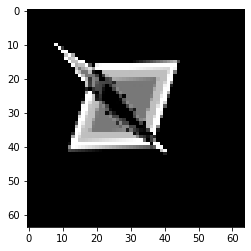

24 diif= 0.11257260291951421 ssd= 154.220703125
alpha 0.5 
 [[ 3.06446078 -1.88299979 -2.71565848]
 [-3.19298004  4.21733165 11.27513277]]


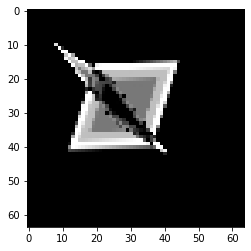

25 diif= 0.21333568520961463 ssd= 153.9464111328125
alpha 0.5 
 [[ 3.03323324 -1.85264202 -2.69507918]
 [-3.19138362  4.22323145 11.06739616]]


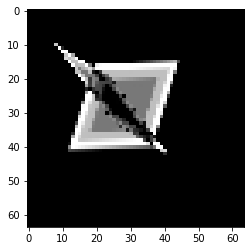

26 diif= 0.22745016148286817 ssd= 153.3985595703125
alpha 0.5 
 [[ 3.00312218 -1.81660919 -2.84234168]
 [-3.19780402  4.23568188 10.90112513]]


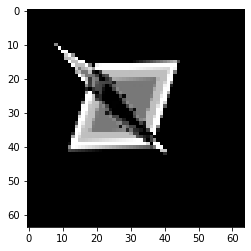

27 diif= 0.23262382600155435 ssd= 153.125
alpha 0.5 
 [[ 2.96918416 -1.78338562 -2.81481349]
 [-3.18990292  4.23564946 10.67520917]]


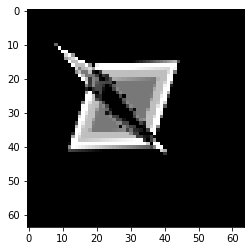

28 diif= 0.362418685477469 ssd= 152.8516845703125
alpha 0.5 
 [[ 2.93979538 -1.74890759 -2.94780994]
 [-3.17375149  4.23123879 10.34155293]]


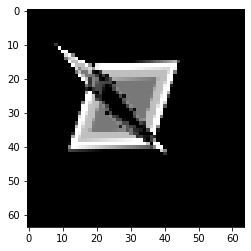

29 diif= 0.27394028526496206 ssd= 152.3057861328125
alpha 0.5 
 [[ 2.90281234 -1.71383596 -2.8888251 ]
 [-3.16233626  4.22888931 10.07919729]]


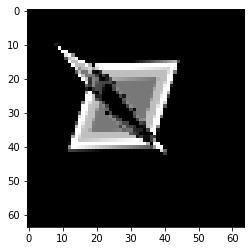

30 diif= 0.09145968286786371 ssd= 152.3057861328125
alpha 0.5 
 [[ 2.87009644 -1.68357261 -2.82376394]
 [-3.15959346  4.22745939 10.03297878]]


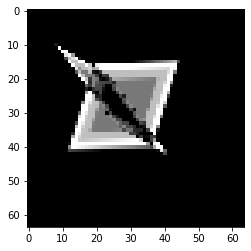

31 diif= 0.23394369305247625 ssd= 152.3057861328125
alpha 0.5 
 [[ 2.83868741 -1.64950371 -2.89357103]
 [-3.14765055  4.22282419  9.81492996]]


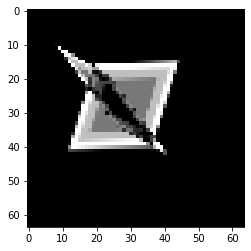

32 diif= 0.31812322191678827 ssd= 151.7608642578125
alpha 0.5 
 [[ 2.79417063 -1.59615381 -3.11467945]
 [-3.15670206  4.22413655 10.03264961]]


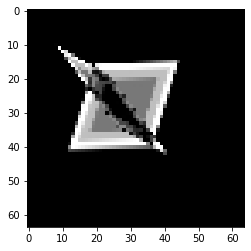

33 diif= 0.3016123291773452 ssd= 151.2169189453125
alpha 0.5 
 [[ 2.72435486 -1.51307833 -3.39114588]
 [-3.15395256  4.22328469  9.98018776]]


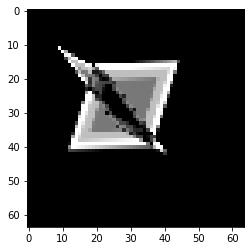

34 diif= 0.21288436213909057 ssd= 150.40283203125
alpha 0.5 
 [[ 2.661901   -1.44358824 -3.54043633]
 [-3.15325261  4.22672229  9.8606451 ]]


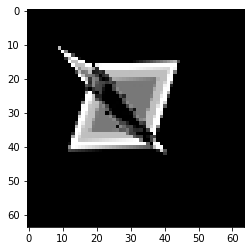

35 diif= 0.2451314739525143 ssd= 150.1319580078125
alpha 0.5 
 [[ 2.60907471 -1.38323093 -3.69545359]
 [-3.1601335   4.22745384 10.03262645]]


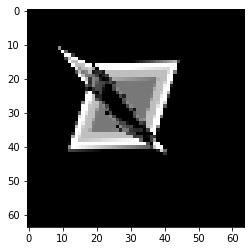

36 diif= 0.2046733809694128 ssd= 149.861328125
alpha 0.5 
 [[ 2.56289723 -1.33547826 -3.69614985]
 [-3.15515483  4.22929716  9.83910682]]


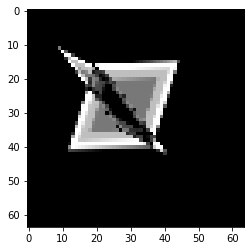

37 diif= 0.26174835916740835 ssd= 149.32080078125
alpha 0.5 
 [[ 2.50647901 -1.26783031 -3.93211148]
 [-3.1588974   4.23046964  9.91023819]]


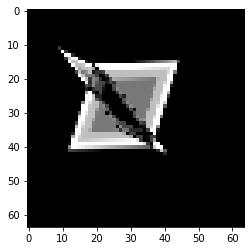

38 diif= 0.1158552254433424 ssd= 148.5118408203125
alpha 0.5 
 [[ 2.4495174  -1.20552461 -3.99080429]
 [-3.1577406   4.2274395   9.96353399]]


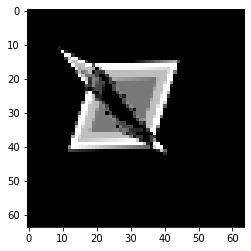

39 diif= 0.16253792567539613 ssd= 148.5118408203125
alpha 0.5 
 [[ 2.40757813 -1.15770364 -4.11218492]
 [-3.15898896  4.22577355 10.05091383]]


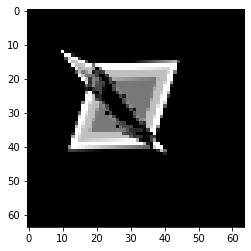

40 diif= 0.0258233549279938 ssd= 148.24267578125
alpha 0.5 
 [[ 2.39045405 -1.14074274 -4.10649092]
 [-3.15649849  4.22295167 10.05718699]]


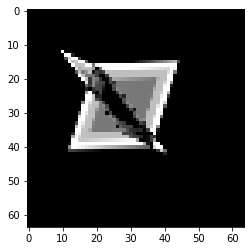

41 diif= 0.32313004233555953 ssd= 148.24267578125
alpha 0.5 
 [[ 2.35637606 -1.09289214 -4.41606254]
 [-3.15373305  4.22267408  9.98563475]]


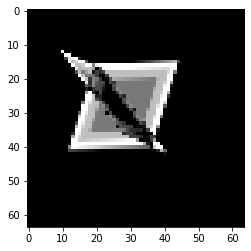

42 diif= 0.12821164389464187 ssd= 147.9737548828125
alpha 0.5 
 [[ 2.32193204 -1.05483362 -4.5291912 ]
 [-3.15351615  4.22347483  9.95393929]]


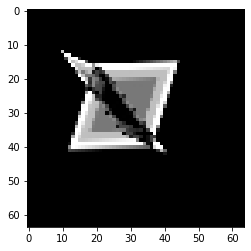

43 diif= 0.3476054439957599 ssd= 147.4366455078125
alpha 0.5 
 [[ 2.27641987 -0.99784586 -4.85986293]
 [-3.14696357  4.21927524  9.87579699]]


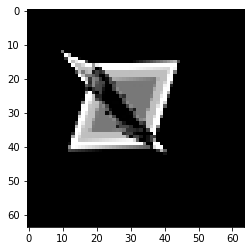

44 diif= 0.40661621140222487 ssd= 146.6328125
alpha 0.5 
 [[ 2.22815671 -0.93570388 -5.19609928]
 [-3.15866747  4.22393639 10.09011497]]


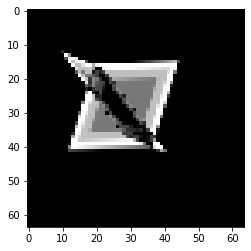

45 diif= 0.18295951426380494 ssd= 146.6328125
alpha 0.5 
 [[ 2.20114815 -0.90351044 -5.36457597]
 [-3.15827881  4.22546852 10.03248329]]


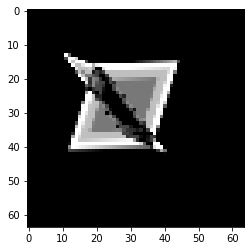

46 diif= 0.14005471002570222 ssd= 146.3653564453125
alpha 0.5 
 [[ 2.17321567 -0.87471645 -5.41412133]
 [-3.16132839  4.22421273 10.15714437]]


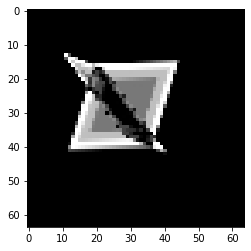

47 diif= 0.3645308149736596 ssd= 145.8311767578125
alpha 0.5 
 [[ 2.12175812 -0.8086058  -5.76676994]
 [-3.15951606  4.22369056 10.11841947]]


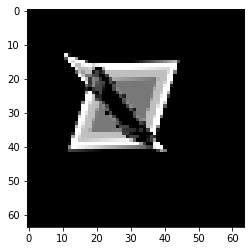

48 diif= 0.30789525790603617 ssd= 144.7657470703125
alpha 0.5 
 [[ 2.05850387 -0.73363333 -6.02793765]
 [-3.15377991  4.22200193  9.98829188]]


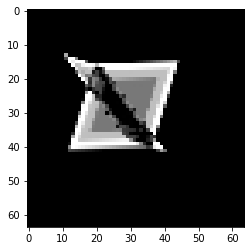

49 diif= 0.38747653362296897 ssd= 144.2344970703125
alpha 0.5 
 [[ 1.99815857 -0.65786486 -6.38930774]
 [-3.14724309  4.21869121  9.8877254 ]]


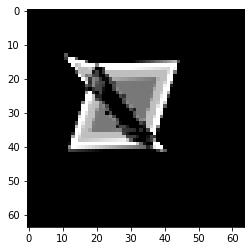

50 diif= 0.377983817184195 ssd= 143.96923828125
alpha 0.5 
 [[ 1.95832698 -0.6237378  -6.19532564]
 [-3.13376283  4.21679062  9.56787204]]


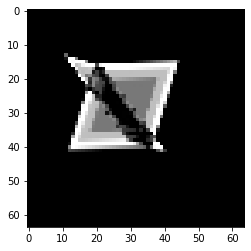

51 diif= 0.32227094380024207 ssd= 142.91064453125
alpha 2.2448380224975972 
 [[ 1.75877466 -0.4139839  -6.08811058]
 [-3.07377001  4.15272755  9.53884703]]


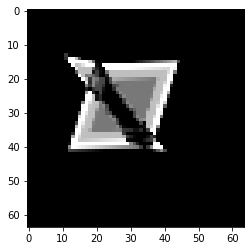

52 diif= 0.15522617192637242 ssd= 142.6466064453125
alpha 0.5 
 [[ 1.7630866  -0.41640848 -6.17436217]
 [-3.0556956   4.13691574  9.41214005]]


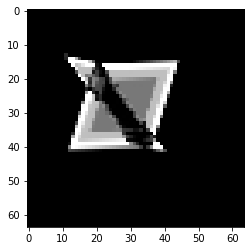

53 diif= 0.3321250238955316 ssd= 142.1192626953125
alpha 0.5 
 [[ 1.752612   -0.39380315 -6.50282526]
 [-3.04246788  4.12344045  9.37416966]]


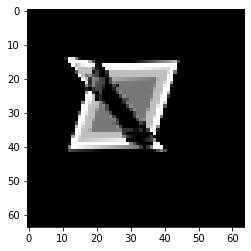

54 diif= 0.27715363037668383 ssd= 141.85595703125
alpha 0.5 
 [[ 1.74169013 -0.37292157 -6.77276984]
 [-3.03294764  4.11445836  9.31744734]]


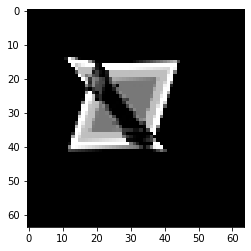

55 diif= 0.25151258193310644 ssd= 141.330078125
alpha 0.5 
 [[ 1.73056777 -0.35438144 -6.96303025]
 [-3.01976858  4.1062139   9.15511911]]


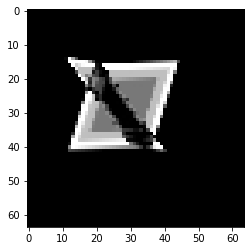

56 diif= 0.3170609803639843 ssd= 141.0675048828125
alpha 0.5 
 [[ 1.72215484 -0.33457462 -7.25716578]
 [-3.01527617  4.10509678  9.03881159]]


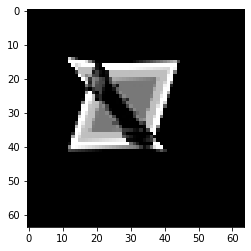

57 diif= 0.33434271552788114 ssd= 140.5430908203125
alpha 0.5 
 [[ 1.7098713  -0.30914098 -7.59021954]
 [-3.01219964  4.10081047  9.04469775]]


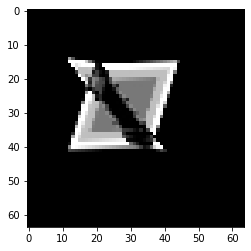

58 diif= 0.960755233388199 ssd= 139.75830078125
alpha 1.8114936721219443 
 [[ 1.67373242 -0.23657836 -8.44892039]
 [-3.00408499  4.07308656  9.46692714]]


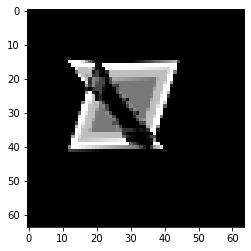

59 diif= 0.08825822912963033 ssd= 139.75830078125
alpha 0.5 
 [[ 1.67601553 -0.24333951 -8.36117865]
 [-3.00104163  4.06957485  9.4626397 ]]


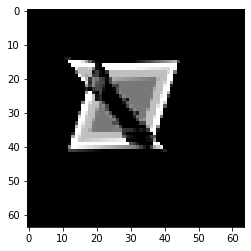

60 diif= 8.808386084713536 ssd= 153.125
alpha 46.7602152389152 
 [[ 1.81571629 -0.67386115 -2.26699994]
 [-2.56604175  3.32831836 15.74794796]]


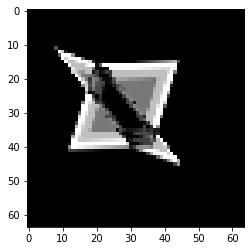

61 diif= 7831.758749747702 ssd= 163.9747314453125
alpha 12180.751083226505 
 [[  247.10185095   128.20638333 -6855.73977803]
 [  257.01046591   -80.7804793  -3754.54731047]]


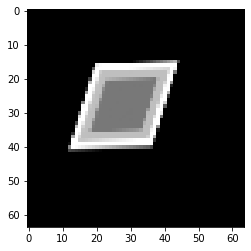

LinAlgError: Singular matrix

In [38]:
A = numpy.zeros((2,3))
A[:,:-1] = numpy.eye(2)
#A = Ab.copy()*(1+numpy.random.rand(2,3)/2)
A = A.reshape(6)
Imax = 1000
eps = 1e-3
step_a = 1e-2
#alpha = 1e-1

N = temp.size
F = GrayImg.AFT(temp,A.reshape(2,3))
da = (numpy.float16(F)-numpy.float16(ref)).reshape(N)/255
ssd0 = (numpy.linalg.norm(da)**2)/2
print(0,'ssd=',ssd0)
plt.imshow(numpy.uint8(255*abs(da.reshape(ref.shape))),cmap='gray')
plt.show()

for k in range(Imax):
    JacT = numpy.zeros((6,N))
    for i in range(6):
        Adf = A.copy()
        Adf[i]+=step_a
        Adb = A.copy()
        Adb[i]-=step_a
        Faf = GrayImg.AFT(temp,Adf.reshape(2,3)) #forward
        Fab = GrayImg.AFT(temp,Adb.reshape(2,3)) #backward
        dai = (numpy.float16(Faf)-numpy.float16(Fab))/255/(2*step_a) 
        JacT[i] = dai.reshape(N)
    H = JacT.dot(numpy.transpose(JacT))
    invH = numpy.linalg.inv(H)
    grad = JacT.dot(da)
    
    #find alpha
    alpha_old = 1e-1
    Aal_old = A - alpha_old*grad
    Fal_old = GrayImg.AFT(temp,Aal_old.reshape(2,3))
    daal_old = (numpy.float16(Fal_old)-numpy.float16(ref)).reshape(N)/255
    ssdal_old = (numpy.linalg.norm(daal_old)**2)/2
    alpha = 0.5
    for j in range(alImax):
        Aal = A - alpha*grad
        Fal = GrayImg.AFT(temp,Aal.reshape(2,3))
        daal = (numpy.float16(Fal)-numpy.float16(ref)).reshape(N)/255
        ssdal = (numpy.linalg.norm(daal)**2)/2
        if abs(ssdal-ssdal_old)<aleps: #avoid devided by zero
            break
        alpha_new = alpha - ssdal*(alpha-alpha_old)/(ssdal-ssdal_old)
        if abs((alpha_new-alpha)/alpha)<aleps:
            alpha = alpha_new
            break
        alpha_old = alpha
        ssdal_old = ssdal
        alpha = alpha_new
    
    A_old = A.copy()
    A -= alpha*invH.dot(grad)
    F = GrayImg.AFT(temp,A.reshape(2,3))
    da = (numpy.float16(F)-numpy.float16(ref)).reshape(N)/255
    ssd = (numpy.linalg.norm(da)**2)/2
    diff = numpy.linalg.norm(A-A_old)
    
    if (k+1)%1==0:
        print(k+1,'diif=',diff,'ssd=',ssd)
        print('alpha',alpha,'\n',A.reshape(2,3))
        #plt.imshow(F,cmap='gray')
        plt.imshow(numpy.uint8(255*abs(da.reshape(ref.shape))),cmap='gray')
        plt.show()
    if diff<eps:
        print('A does not change')
        break
    if (ssd/ssd0)<eps:
        print('Converge')
        break   